## Cover Song Identification using comparison of hierarchical structure for covers80

### Library Importing

In [1]:
import librosa
import numpy as np
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp2d
from scipy.sparse.csgraph import laplacian
from scipy.spatial.distance import directed_hausdorff
from scipy.cluster import hierarchy
from scipy.linalg import eigh
from scipy.ndimage import median_filter
import cv2
from sklearn import metrics
import matplotlib.pyplot as plt
import dill
import sys
import glob
import os
import random

### Dill session

In [53]:
dill.dump_session('../../../dills/covers80_all.db')

In [ ]:
dill.load_session('../../../dills/covers80_all.db')

### Load audio

In [2]:
#Choose directory containing audiofiles
directory = '../../../Datasets/covers80/covers32k'

In [3]:
#Read all paths in specified directory
all_dirs = []
all_roots = []
all_names= []
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name) or ('.mp3' in name)):
                filepath = os.path.join(root, name)
                all_dirs.append(filepath)
                all_names.append(name[:-4])
                all_roots.append(root)
file_no = len(all_names)
#Load all audiofiles and store in array
all_audio = []
for f in range(file_no):
    y, sr = librosa.load(all_dirs[f], sr=16000, mono=True)
    all_audio.append((y, sr))
    sys.stdout.write("\rLoaded %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

ile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 73/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 74/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 75/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
Loaded 76/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying au

### Hierarchical structure decomposition

In [33]:
#CQT config
BINS_PER_OCTAVE = 12*3
N_OCTAVES = 7

#Approximations
kmin = 2
kmax = 8

all_struct = []

for i in range(file_no):
    y, sr = all_audio[i]
   
    C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr,
                                        bins_per_octave=BINS_PER_OCTAVE,
                                        n_bins=N_OCTAVES * BINS_PER_OCTAVE)),
                            ref=np.max)
    
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)

    Csync = librosa.util.sync(C, beats, aggregate=np.median)

    Cstack = librosa.feature.stack_memory(Csync, 4)
    
    R = librosa.segment.recurrence_matrix(Cstack, width=3, mode='affinity', sym=True)

    df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
    Rf = df(R, size=(1, 7))
    Rf = librosa.segment.path_enhance(Rf, 15)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    Msync = librosa.util.sync(mfcc, beats)

    path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)

    R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

    deg_path = np.sum(R_path, axis=1)
    deg_rec = np.sum(Rf, axis=1)

    mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

    A = mu * Rf + (1 - mu) * R_path

    A_d = cv2.resize(A, (128,128))
    
    L = scipy.sparse.csgraph.laplacian(A_d, normed=True)
    
    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(L)
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    dist_set = []
    for k in range(kmin, kmax):
        Xs = evecs[:, :k] / Cnorm[:, k-1:k]
        distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
        dist_set.append(distance)
    all_struct.append(dist_set)    

    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
    

ges/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Computed for 93/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Computed for 94/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Computed for 95/160 pieces./Users/chris/Library/Python/3.8/lib/python/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce emp

In [35]:
all_struct = np.asarray(all_struct)
print(all_struct.shape)

(160, 6, 128, 128)


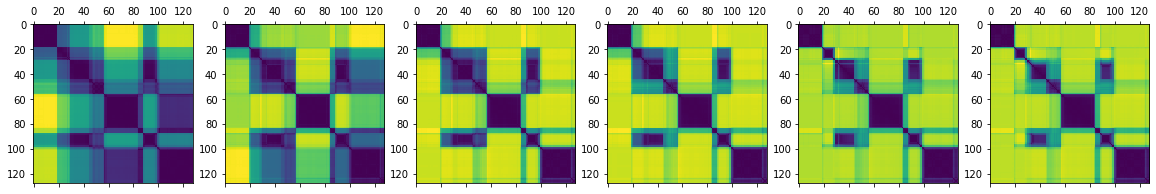

In [36]:
fig, axs = plt.subplots(1, kmax-kmin, figsize=(20, 20))
for i in range(kmax-kmin):
    axs[i].matshow(all_struct[5][i])
plt.show()

### Flatten approximation matrices and concatenate them

In [61]:
all_flat = []
all_merged = []

for i in range(file_no):

    flat_approximations = []
    merged_approximations = np.empty((0))

    for j in range(kmax-kmin):
        flat_approximations.append(all_struct[i][j].flatten())
        merged_approximations = np.concatenate((merged_approximations, flat_approximations[j]))
    all_flat.append(np.asarray(flat_approximations))
    all_merged.append(merged_approximations)

    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()

all_flat = np.asarray(all_flat)
all_merged = np.asarray(all_merged)
print(all_flat.shape, all_merged.shape)

Computed for 160/160 pieces.(160, 6, 16384) (160, 98304)


### Boolean, pairwise matrix for cover (True) vs non-cover (False)

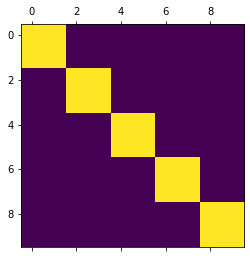

In [59]:
#True if cover, False if non-cover
covers = np.zeros((file_no, file_no), dtype=np.bool_)
for i in range(file_no):
    for j in range(file_no):
        if (all_roots[i] == all_roots[j]):
            covers[i][j] = True
        else:
            covers[i][j] = False
plt.matshow(covers[:10, :10])
plt.show()

### L1 norm

Computed for 160/160 pieces.

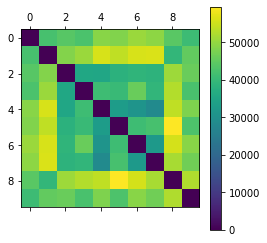

In [62]:
L1_distances = np.zeros((file_no, file_no))
for i in range(file_no):
    for j in range(file_no):
        L1_distances[i][j] = np.linalg.norm(all_merged[i]-all_merged[j], ord=1)
    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
plt.matshow(L1_distances[:10, :10])
plt.colorbar()
plt.show()

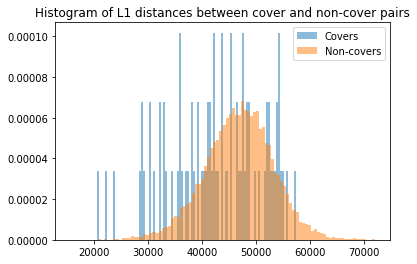

In [64]:
L1_distances_covers = []
L1_distances_noncovers = []
for i in range(all_flat.shape[0]):
    for j in range(all_flat.shape[0]):
        if covers[i][j]:
            if (L1_distances[i][j] != 0):
                L1_distances_covers.append(L1_distances[i][j])
        else:
            L1_distances_noncovers.append(L1_distances[i][j])
            
plt.figure()
plt.hist(L1_distances_covers, bins=100, alpha=0.5, label='Covers', density=1)
plt.hist(L1_distances_noncovers, bins=100, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of L1 distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Frobenius norm

Computed for 160/160 pieces.

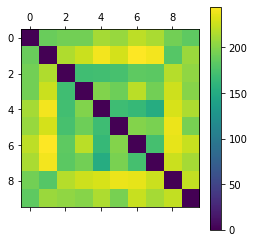

In [74]:
fro_distances = np.zeros((file_no, file_no))
for i in range(file_no):
    for j in range(file_no):
        fro_distances[i][j] = np.linalg.norm(all_merged[i]-all_merged[j])
    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
plt.matshow(fro_distances[:10, :10])
plt.colorbar()
plt.show()

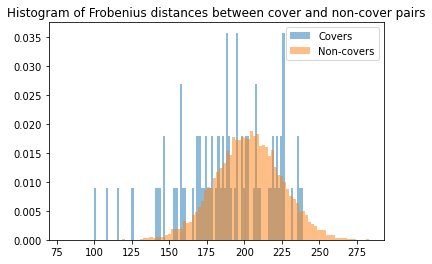

In [75]:
fro_distances_covers = []
fro_distances_noncovers = []
for i in range(all_flat.shape[0]):
    for j in range(all_flat.shape[0]):
        if covers[i][j]:
            if (fro_distances[i][j] != 0):
                fro_distances_covers.append(fro_distances[i][j])
        else:
            fro_distances_noncovers.append(fro_distances[i][j])
            
plt.figure()
plt.hist(fro_distances_covers, bins=100, alpha=0.5, label='Covers', density=1)
plt.hist(fro_distances_noncovers, bins=100, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of Frobenius distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Sub-sequence Dynamic Time Warping cost

Computed for 160/160 pieces.

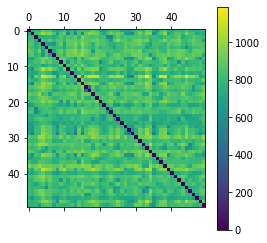

In [82]:
dtw_cost = np.zeros((file_no, file_no))
for i in range(file_no):
    for j in range(file_no):
        costs = []
        for k in range(kmax-kmin):           
            costs.append(librosa.sequence.dtw(all_struct[i][k], all_struct[j][k], subseq=True, metric='euclidean')[0][127,127])
        dtw_cost[i][j] = sum(costs)/len(costs)
    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
plt.matshow(dtw_cost[:50, :50])
plt.colorbar()
plt.show()

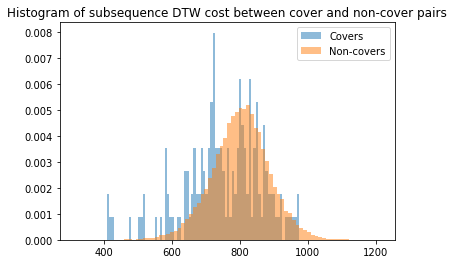

In [85]:
dtw_cost_covers = []
dtw_cost_noncovers = []
for i in range(file_no):
    for j in range(file_no):
        if covers[i][j]:
            if (dtw_cost[i][j] != 0):
                dtw_cost_covers.append(dtw_cost[i][j])
        else:
            dtw_cost_noncovers.append(dtw_cost[i][j])
            
plt.figure()
plt.hist(dtw_cost_covers, bins=100, alpha=0.5, label='Covers', density=1)
plt.hist(dtw_cost_noncovers, bins=100, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of subsequence DTW cost between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Directed Hausdorff distance

Computed for 160/160 pieces.

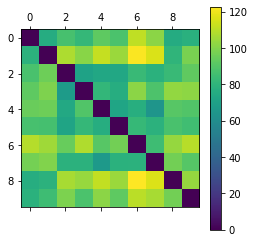

In [98]:
hausdorff_distances = np.zeros((file_no, file_no))
for i in range(file_no):
    for j in range(file_no):
        hausdorff_distances[i][j] = (directed_hausdorff(all_flat[i], all_flat[j]))[0]
    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
plt.matshow(hausdorff_distances[:10, :10])
plt.colorbar()
plt.show()

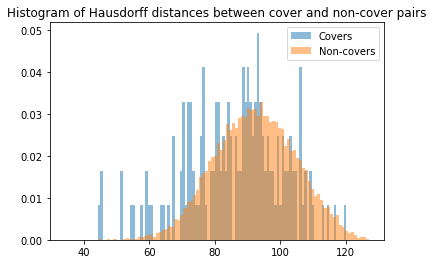

In [100]:
hausdorff_distances_covers = []
hausdorff_distances_noncovers = []
for i in range(file_no):
    for j in range(file_no):
        if covers[i][j]:
            if (hausdorff_distances[i][j] != 0):
                hausdorff_distances_covers.append(hausdorff_distances[i][j])
        else:
            hausdorff_distances_noncovers.append(hausdorff_distances[i][j])
            
plt.figure()
plt.hist(hausdorff_distances_covers, bins=100, alpha=0.5, label='Covers', density=1)
plt.hist(hausdorff_distances_noncovers, bins=100, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of Hausdorff distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()

### Minimum distance from Y1i to Y2j for all (i,j)

Computed for 160/160 pieces.

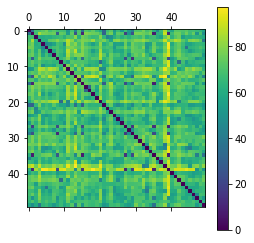

In [101]:
min_distances = np.zeros((file_no, file_no))
for i in range(file_no):
    for j in range(file_no):
        dists = []
        for n in range(kmax-kmin):
            for m in range(kmax-kmin):
                dists.append(np.linalg.norm(all_struct[i][n]-all_struct[j][m]))
        min_distances[i][j] = min(dists)
    sys.stdout.write("\rComputed for %i/%s pieces." % ((i+1), str(file_no)))
    sys.stdout.flush()
plt.matshow(min_distances[:50, :50])
plt.colorbar()
plt.show()

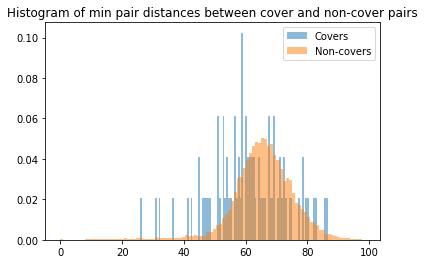

In [102]:
min_distances_covers = []
min_distances_noncovers = []
for i in range(file_no):
    for j in range(file_no):
        if covers[i][j]:
            if (min_distances[i][j] != 0):
                min_distances_covers.append(min_distances[i][j])
        else:
            min_distances_noncovers.append(min_distances[i][j])
            
plt.figure()
plt.hist(min_distances_covers, bins=100, alpha=0.5, label='Covers', density=1)
plt.hist(min_distances_noncovers, bins=100, alpha=0.5, label='Non-covers', density=1)
plt.title("Histogram of min pair distances between cover and non-cover pairs")
plt.legend(loc='upper right')
plt.show()